# Loco learning MNIST

A simple example on how to train MNIST digits, step by step

## About the MNIST dataset

The postal service of the United States provided this dataset years ago. It consists on thousends of 28x28 pixels images repressenting a handwritten digit, they are correctly labeled (from 0 to 9). 

The images are grayscale, so each pixel is represented by a value that goes from 0 to 255.

Because it is a well known dataset, it is perfect to be used as a first project for machine learning.



In [1]:
# first, lets load the basics
from IPython.display import display, Image
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
import numpy as np
import requests
import sys
import os.path


Now lets get the MNIST dataset. 

There are a number of formats out there, and typically you should read the images directly and convert them into a matrix, but in order to save time and be focus on the problem we will download a CSV version directly.

The format is the following.

Each image is 28x28 pixels, those are reshaped into a single dimensions of 28*28 = 784 values. Also we need to know which digits corresponds to each image, so before those 784 values we add a number (from 0 to 9) that tells use which one is the digit on the image. That gives us 784 + 1 = 785 columns, where the first element is the digit itself.

We will define a simple ```download_file``` function to do the downloading for us.

In [2]:
def download_file(link, file_name):
    # Credit goes to ==> https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads
    if os.path.isfile(file_name):
        print("File was already there")
    else:
        with open(file_name, "wb") as f:
            print ("Downloading %s" % file_name)
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()
    return file_name

Now, lets get the train data and the test data

In [3]:
mnist_filename = "train.csv"
download_file("https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv", mnist_filename)

File was already there


'train.csv'

It is important now to understand the format of the files

From http://makeyourownneuralnetwork.blogspot.com.au/2015/03/the-mnist-dataset-of-handwitten-digits.html


The first value is the "label", that is, the actual digit that the handwriting is supposed to represent, such as a "7" or a "9". It is the answer to which the neural network is aspiring to classify.

The subsequent values, all comma separated, are the pixel values of the handwritten digit. The size of the pixel array is 28 by 28, so there are 784 values after the label.

So the first thing we need to do is separate the actual labels from the data itself, we will call the data X and the labels y, as we have a train and a test set, we will call them X_train, X_test, y_train, y_test







In [4]:
mnist = pd.read_csv(mnist_filename).as_matrix() # We need to call as_matrix so we can use numpy arrays

So the first thing we need to do is separate the actual labels from the data itself, we will call the data X and the labels y, as we have a train and a test set, we will call them X_train, X_test, y_train, y_test

In numpy this is pretty easy, when operating with a matrix (lets call it MATRIX), one has to provide which rows and columns are to be used. One can simply access row 5 and column 20 by doing MATRIX[5, 20]. 

In our case we want the first column and ALL the rows, that is done by effectively selecting all the rows with 
```
:
``` 
so 

```
train[:,0]
```

For the data itself we want ALL the rows and all the columns except the first one, as everything is zero-indexed, we want everything from the column number one, that is done by using

```
1:
```

so

```
train[:, 1:]
```

In [5]:

train_split = int(mnist.shape[0] * 0.8)
train = mnist[0:train_split,]
test = mnist[train_split:,]

y_train = train[:,0]
X_train = train[:,1:]
y_test = test[:, 0]
X_test = test[:,1:]

Now lets make sure that our shapes are correct, the data should be in shape Nx786 where N is the number of rows, in the case of y, the shape should be N, where N again is the number of rows

In [6]:
print("Shape of X_train ", X_train.shape, " y_train ", y_train.shape)
print("Shape of X_test ", X_test.shape, " y_test ", y_test.shape)

Shape of X_train  (33600, 784)  y_train  (33600,)
Shape of X_test  (8400, 784)  y_test  (8400,)


Lets do a simple explorarion of the dataset, lets grab the first element

In [7]:
sample = X_train[42,]
sample_label = y_train[42]

In [8]:
sample

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 231,  11,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 202,  92,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  60, 244, 116,   0,   

Remember that the values are the pixels, and they are represented in a vector of 28x28 = 784 pixels, lets reshape this sample to its original form so we can display the image.



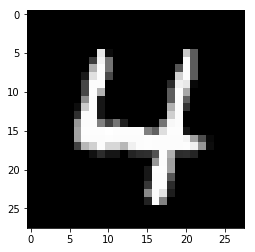

Label is 4


In [9]:
sample_image = sample.reshape((28,28))
plt.imshow(sample_image, cmap='gray')
plt.show()
print("Label is", sample_label)

Now, as we are dealing with 

In [10]:
print("Min value is ", np.min(X_train))
print("Max value is ", np.max(X_train))

Min value is  0
Max value is  255


No surprises here, as we are dealing with grayscale images, values range from 0 to 255, but neuronal networks like values around zero due to numerical stability reasons. We are going to convert them using max-min scaling

The formula to use is 

![title](normalization.png)


In [11]:
max_value = np.max(X_train)
min_value = np.min(X_train)

X_train_normalized = (X_train - min_value) / (max_value - min_value)
X_test_normalized = (X_test - min_value) / (max_value - min_value)

And lets verify some random values to make triple sure everything is fine

In [12]:
X_train_normalized[42,]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Now lets have a look at the ```y``` values

In [13]:
print(y_train[0:10])

[1 0 1 4 0 0 7 3 5 3]


Makes sense, we seem to have different digits from 0 to 9, however we want them to be ```one-hot-encoded``` that is, 
if the value is 2 then we want a vector of 10 elements looking like 
```
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
```

And if the value was say, 8, then the vector would look like

```
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
```


In [14]:
y_train_one_hot = np.eye(10)[y_train.reshape(-1)]
y_test_one_hot = np.eye(10)[y_test.reshape(-1)]

Now lets verify, remember the output for the first 10 elements was
```
array([0, 4, 1, 9, 2, 1, 3, 1, 4, 3])
```

In [15]:
print("New shape for labels (train set) ", y_train_one_hot.shape)
y_train_one_hot[0:10]

New shape for labels (train set)  (33600, 10)


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now lets start playing with the interesting stuff. 

Initially a simple logistic regression is going to be done using tensorflow.

In [16]:
epochs = 10 # How many passes on all the data
batch_size = 256 # We will pass 256 examples each time
total_batches = X_train_normalized.shape[0] // batch_size # How many batches we will use
columns = 784 # Remember, we are dealing with images of 28x28 pixels unrolled as 28*28 = 786
labels = 10 # There are 10 possible labels (as we have 10 digits from 0 to 9)

weights = tf.Variable(tf.truncated_normal(shape=(columns, labels), stddev=0.1))
biases = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

predictions = tf.add(tf.matmul(X, weights), biases)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [17]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print("Accuracy so far ", accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))    

Accuracy so far  0.137202
Accuracy so far  0.822113
Accuracy so far  0.844107
Accuracy so far  0.873304
Accuracy so far  0.88
Accuracy so far  0.889762
Accuracy so far  0.894018
Accuracy so far  0.898839
Accuracy so far  0.902054
Accuracy so far  0.90506
Accuracy so far  0.907173
Accuracy so far  0.909048
Accuracy so far  0.91128
Accuracy so far  0.913006
Accuracy so far  0.91381
Accuracy so far  0.915387
Accuracy so far  0.915863
Accuracy so far  0.917321
Accuracy so far  0.917798
Accuracy so far  0.91872
Final accuracy on test set
0.918571


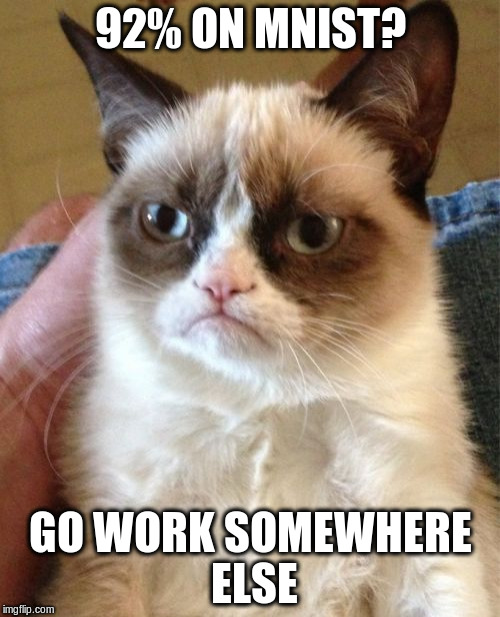

In [18]:
display(Image('grumpy01.jpg', width=400))

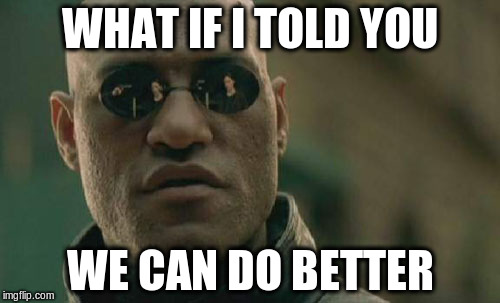

In [19]:
display(Image('morhpeo01.jpeg', width=400))

### If instead using logistic regression we use a neuronal network, we will increase the performance substantially.

![title](nerualnet.png)

A neuronal network is composed of 1 or more hidden layer, in this example we will be adding a single hidden layer of 100 units

In [20]:
hidden_units = 100

weights = tf.Variable(tf.truncated_normal(shape=(columns, hidden_units), stddev=1/(hidden_units**0.5)))
biases = tf.Variable(tf.zeros(hidden_units))

weights_output = tf.Variable(tf.truncated_normal(shape=(hidden_units, labels), stddev=1/(labels**0.5)))
biases_output = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

hidden_output = tf.add(tf.matmul(X, weights), biases)
hidden_output = tf.nn.relu(hidden_output)
#hidden_output = tf.nn.dropout(hidden_output, 0.7)

predictions = tf.add(tf.matmul(hidden_output, weights_output), biases_output)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))    

0.0973214
0.907589
0.917738
0.937381
0.943363
0.949732
0.954851
0.958185
0.9625
0.964375
0.968988
0.969048
0.97378
0.972649
0.977679
0.975565
0.980714
0.97875
0.983065
0.981518
Final accuracy on test set
0.967976


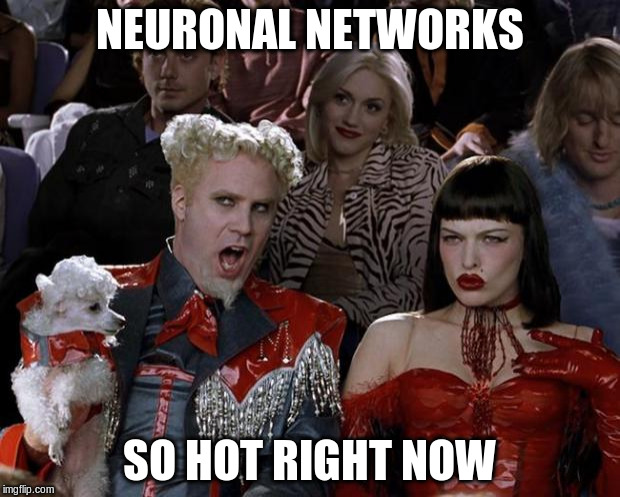

In [21]:
display(Image('zoolander01.jpeg', width=400))

Using a neuronal network gives us a 96.6% accuracy, much better than the initial 92% achieve with logistic regression. 

Can we do better? Sure we can, but before that, lets rewrite the code with a higher level api provided by tensorflow, so we do not have to initialize weights or perform matrix multiplications ourselves.

In [22]:
hidden_units = 100

epochs = 10
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output = tf.layers.dense(X, hidden_units, activation = tf.nn.relu)
predictions = tf.layers.dense(hidden_output, labels)  
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

0.158899
0.909256
0.918482
0.932143
0.938095
0.944137
0.949226
0.952351
0.956875
0.957827
0.963304
0.96253
0.968363
0.966548
0.97253
0.969583
0.975476
0.972589
0.978095
0.975387
Final accuracy on test set
0.964762


As you can see, with the higher level api, the code gets much smaller, we can easily define our neuronal network layers just paying attention to the number of hidden units and the activation function, no need to initialize weights or perform matrix multiplications. 

Now it is the time to ...



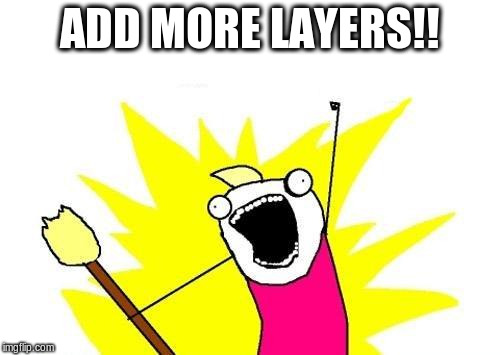

In [23]:
display(Image('moreLayers01.jpeg', width=400))

In [24]:
hidden_units_1 = 256
hidden_units_2 = 128

epochs = 10
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output_1 = tf.layers.dense(X, hidden_units_1, activation = tf.nn.relu)
hidden_output_2 = tf.layers.dense(hidden_output_1, hidden_units_2, activation = tf.nn.relu)

predictions = tf.layers.dense(hidden_output_2, labels)  
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

0.286786
0.934613
0.94372
0.961726
0.964345
0.973512
0.975298
0.981964
0.982173
0.985536
0.986071
0.98744
0.988244
0.989226
0.989673
0.989554
0.988393
0.987976
0.987232
0.984702
Final accuracy on test set
0.967857


We have got a bit better, 97.36% accuracy from the previous 96.5%

What if we train our network for more epochs?

In [25]:
hidden_units_1 = 256
hidden_units_2 = 128

epochs = 30
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output_1 = tf.layers.dense(X, hidden_units_1, activation = tf.nn.relu)
hidden_output_2 = tf.layers.dense(hidden_output_1, hidden_units_2, activation = tf.nn.relu)

predictions = tf.layers.dense(hidden_output_2, labels)  
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

0.237173
0.935595
0.946488
0.961815
0.966696
0.973304
0.976429
0.980149
0.981399
0.983363
0.983899
0.984732
0.984583
0.987173
0.98622
0.988274
0.987321
0.984613
0.990179
0.990089
0.994792
0.991786
0.996369
0.990774
0.997351
0.98622
0.996845
0.991429
0.997083
0.995833
0.995089
0.9975
0.997173
0.992976
0.995685
0.998214
0.997649
0.999316
0.997619
0.999435
0.999048
0.999821
0.999613
0.99997
0.99994
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
0.99997
Final accuracy on test set
0.979405


Now we are in 97.78% which is a small improvement compared to the previous 97.36%, we could try to add more layers, but that is not going to solve things... we need to use other technique.

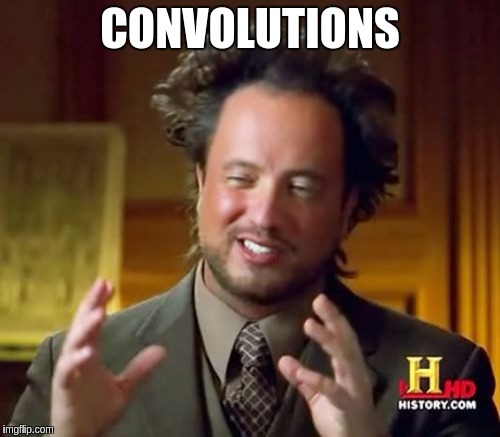

In [26]:
display(Image('aliens01.jpg', width=400))

In [40]:
hidden_units_1 = 512
hidden_units_2 = 256
batch_size = 128
epochs = 10
X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
    
   
# First convolution turns image into a 28x28x16
convolution_1 = tf.layers.conv2d(X,    
                                 16, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)



# Max pool to reduce image from 28x28x16 to 14x14x16   
convolution_1 = tf.layers.max_pooling2d(convolution_1, 
                                        1,  # Kernel/patch size 
                                        2,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 28 / 2 = 14
                                        padding="SAME")



# Now, second convolution Goes from 14x14x16 to 7x7x32
convolution_2 = tf.layers.conv2d(convolution_1,    
                                 32, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)


convolution_2 = tf.layers.max_pooling2d(convolution_2, 
                                        1,  # Kernel/patch size 
                                        2,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 14 / 2 = 7
                                        padding="SAME")

# So the output of the convolution is 7x7x32 = 1568, lets use that for a "normal" neural network



fully_connected_1 = tf.layers.dense(tf.reshape(convolution_2, (-1, 7*7*32)),
                                hidden_units_1, 
                                activation=tf.nn.relu)

fully_connected_2 = tf.layers.dense(fully_connected_1,
                                hidden_units_2, 
                                activation=tf.nn.relu)


predictions = tf.layers.dense(fully_connected_2, labels)  
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [ ]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
debug = True
for epoch_no in range(epochs):
    
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]
        
        X_chunk = X_chunk.reshape((-1, 28, 28, 1)) # Reshape our 784 vectors to 28x28x1 images
        if debug:
            debug = False
            print("Convolution 1", convolution_1.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Convolution 2", convolution_2.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Fully connected 1", fully_connected_1.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Fully connected 2", fully_connected_2.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 50 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print("Epoch ", epoch_no, 
                  " batch number ", batch_no, 
                  " \taccuracy ", accuracy.eval(feed_dict={X: X_train_normalized.reshape((-1, 28, 28, 1)), 
                                                         y: y_train_one_hot}))
            
            
    
#print("Final accuracy on test set")
#correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))     

Convolution 1 (128, 14, 14, 16)
Convolution 2 (128, 7, 7, 32)
Fully connected 1 (128, 512)
Fully connected 2 (128, 256)
Epoch  0  batch number  0  	accuracy  0.373065
Epoch  0  batch number  50  	accuracy  0.897202
Epoch  0  batch number  100  	accuracy  0.927024
Epoch  1  batch number  0  	accuracy  0.945387
Epoch  1  batch number  50  	accuracy  0.957738
Epoch  1  batch number  100  	accuracy  0.963423
Epoch  2  batch number  0  	accuracy  0.973095
Epoch  2  batch number  50  	accuracy  0.974167
Epoch  2  batch number  100  	accuracy  0.974911
Epoch  3  batch number  0  	accuracy  0.973958
Epoch  3  batch number  50  	accuracy  0.977619
Epoch  3  batch number  100  	accuracy  0.980923


In [39]:
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized.reshape((-1, 28, 28, 1)), y: y_test_one_hot}))  

Final accuracy on test set
0.981548
